# ✨ Proyecto: Ingesta, Transformación y Visualización de Datos NYC Taxi Trips (Adaptado para Google Colab)

## 📄 Objetivo del Proyecto

Este proyecto tiene como fin que aprendáis y practiquéis el ciclo completo de un flujo de datos ETL (Extracción, Transformación y Carga) utilizando PySpark. Se trabajará con datos reales de viajes de taxi en Nueva York, disponibles de forma pública. Esta versión está adaptada para ejecutarse en Google Colab.

### Caso empresarial:
Una empresa de transporte de taxis en Nueva York ha recopilado durante años datos de sus viajes (fecha, ubicación de recogida y destino, tarifas, número de pasajeros, etc.). Actualmente, dispone de estos archivos en formato CSV y ha solicitado tu ayuda como ingeniero/a de datos para lograr lo siguiente:

1. Implementar un pipeline de datos que:
   * Ingesta automáticamente nuevos archivos mensuales de viajes.
   * Procese y limpie los datos (fechas, ubicaciones, tarifas, pasajeros).
   * Agregue estadísticas útiles por hora o zona.
   * Almacene los resultados en un formato eficiente (Parquet o CSV en Colab).

2. Construir un dashboard visual con insights clave del negocio:
   * Horas con más pasajeros.
   * Tarifas promedio.
   * Distancias recorridas.
   (En Colab, esto se realizará mediante librerías de visualización como Matplotlib, Seaborn o Plotly).

3. Automatizar este flujo para que se ejecute al detectar nuevos archivos o en intervalos regulares.
   (En Colab, la automatización tiene limitaciones; se explicarán las opciones).

🧠 Aprendizajes del proyecto:

*   Configurar e inicializar PySpark en Google Colab.
*   Usar PySpark para cargar, transformar y agregar datos.
*   Almacenar resultados en formatos como Parquet.
*   Comprender cómo adaptar pipelines ETL a diferentes entornos.
*   Construir visualizaciones de datos en notebooks de Colab.

# 🏢 Parte 1: Preparación del Entorno en Google Colab

## ▶ Qué es Google Colab y por qué lo usamos para PySpark

**Google Colaboratory (Colab)** es un servicio gratuito en la nube de Google Research que permite escribir y ejecutar Python en tu navegador. Es especialmente útil para machine learning, análisis de datos y educación.

### Ventajas para este proyecto:
- No requiere configuración local de Spark; podemos instalarlo directamente en el entorno de Colab.
- Proporciona un entorno de notebook interactivo similar a Jupyter.
- Permite el acceso a GPUs y TPUs gratuitas (aunque no las necesitaremos para este proyecto de PySpark básico).
- Fácil integración con Google Drive para almacenamiento de datos.

A diferencia de Databricks, que es una plataforma especializada en Big Data con Spark integrado, en Colab necesitamos instalar y configurar PySpark manualmente.

In [ ]:
# Instalar PySpark y findspark
# findspark se utiliza para localizar Spark en el sistema e inicializarlo correctamente.
!pip install -q pyspark findspark

In [ ]:
import findspark
findspark.init() # Encuentra la instalación de Spark

from pyspark.sql import SparkSession

# Crear una SparkSession
import findspark
findspark.init() # Encuentra la instalación de Spark

from pyspark.sql import SparkSession

# Crear una SparkSession
# appName: Nombre de tu aplicación Spark.
# master: "local[*]" indica que Spark se ejecutará localmente usando todos los núcleos disponibles.
spark = SparkSession.builder \
    .appName("NYCTaxiETLColab") \
    .master("local[*]") \
    .getOrCreate()

print(spark)
# También puedes acceder al SparkContext a través de la SparkSession
sc = spark.sparkContext
print(sc)
# También puedes acceder al SparkContext a través de la SparkSession
sc = spark.sparkContext
print(sc)

<SparkContext master=local[*] appName=NYCTaxiETLColab>
<SparkContext master=local[*] appName=NYCTaxiETLColab>


# 🚜 Parte 2: Ingesta de Datos

## 📃 Dataset: NYC Yellow Taxi Trips

- Fuente oficial: [NYC TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- Ejemplo de archivo: `yellow_tripdata_2019-01.parquet` (Anteriormente CSV)

En Google Colab, descargaremos el archivo directamente al sistema de archivos temporal de la instancia de Colab. Si necesitas persistencia, puedes montar tu Google Drive y guardar/leer archivos desde allí.

In [46]:
# Celda para definir los enlaces de los archivos Parquet y seleccionar cuáles descargar
import json
import urllib.request
import os

# Cargar los enlaces de los archivos Parquet (asumiendo que parquet_links.json está en /content/)
# Para este ejemplo, vamos a definir una lista corta de URLs directamente.
# En un caso real, subirías parquet_links.json a Colab y lo leerías aquí.
# O podrías incluir el código de scraping directamente en una celda anterior.

# Ejemplo de enlaces (puedes ampliar esta lista o cargarla desde el JSON)
parquet_files_to_download = [
    {"text": "Yellow Taxi Trip Records 2022-01", "href": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet"},
    {"text": "Yellow Taxi Trip Records 2022-02", "href": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet"},
    #{"text": "Green Taxi Trip Records 2023-01", "href": "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet"},
    # Puedes añadir más archivos aquí, por ejemplo, el que mencionó el usuario:
    # {"text": "Green Taxi Trip Records 2019-02", "href": "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2019-02.parquet"}
]

data_dir = "/content/data"
os.makedirs(data_dir, exist_ok=True)
downloaded_file_paths = []

print(f"Archivos Parquet seleccionados para descarga: {len(parquet_files_to_download)}")
for i, file_info in enumerate(parquet_files_to_download):
    file_name = os.path.basename(file_info["href"])
    local_path = os.path.join(data_dir, file_name)
    url = file_info["href"]
    print(f"Procesando ({i+1}/{len(parquet_files_to_download)}): {file_name}")
    if not os.path.exists(local_path):
        try:
            print(f"  Descargando {file_name} a {local_path}...")
            urllib.request.urlretrieve(url, local_path)
            print(f"  Descarga completa: {file_name}")
            downloaded_file_paths.append(local_path)
        except Exception as e:
            print(f"  Error al descargar {file_name}: {e}")
    else:
        print(f"  El archivo {file_name} ya existe en {local_path}.")
        downloaded_file_paths.append(local_path) # Asegurarse de que se incluye si ya existe

print("Proceso de descarga finalizado.")
print(f"Total de archivos locales listos para procesar: {len(downloaded_file_paths)}")
# Verificar que los archivos están allí (opcional)
!ls -lh {data_dir}

Archivos Parquet seleccionados para descarga: 2
Procesando (1/2): yellow_tripdata_2022-01.parquet
  Descargando yellow_tripdata_2022-01.parquet a /content/data/yellow_tripdata_2022-01.parquet...
  Descarga completa: yellow_tripdata_2022-01.parquet
Procesando (2/2): yellow_tripdata_2022-02.parquet
  Descargando yellow_tripdata_2022-02.parquet a /content/data/yellow_tripdata_2022-02.parquet...
  Descarga completa: yellow_tripdata_2022-02.parquet
Proceso de descarga finalizado.
Total de archivos locales listos para procesar: 2
total 381M
-rw-r--r-- 1 root root  99M May  6 10:13 yellow_tripdata_2019-02.parquet
-rw-r--r-- 1 root root 111M May  6 10:14 yellow_tripdata_2019-03.parquet
-rw-r--r-- 1 root root  37M May  6 10:19 yellow_tripdata_2022-01.parquet
-rw-r--r-- 1 root root  44M May  6 10:19 yellow_tripdata_2022-02.parquet
-rw-r--r-- 1 root root  46M May  6 10:16 yellow_tripdata_2023-01.parquet
-rw-r--r-- 1 root root  46M May  6 10:16 yellow_tripdata_2023-02.parquet


**Explicación paso a paso:**
- `urllib.request`: Esta línea descarga el archivo Parquet desde la URL pública y lo guarda localmente en el directorio `/content/data/` de la instancia de Colab.
- `os.makedirs`: Crea el directorio si no existe.
- `spark.read.parquet`: Esta línea utiliza PySpark para leer el archivo Parquet desde la ubicación local en Colab.
  - El formato Parquet es un formato de almacenamiento columnar eficiente que autodescribe el esquema de los datos. Por lo tanto, no necesitamos opciones como `header=True` o `inferSchema=True` que se usan con CSV.
- `df.printSchema()`: Es una buena práctica imprimir el esquema del DataFrame después de leerlo para verificar que los tipos de datos y los nombres de las columnas son los esperados.
El resultado se guarda como un DataFrame de Spark, que es la estructura principal para manipular datos distribuidos.

In [39]:
# Leer Parquet con Spark
# Asegúrate de que la ruta al archivo es correcta.
parquet_file_path = f"file://{local_path}" # 'file://' es necesario para rutas locales absolutas en Spark

try:
    df = spark.read.parquet(parquet_file_path)
    print("DataFrame Parquet cargado exitosamente.")
    print("Esquema del DataFrame:")
    df.printSchema()
    print("Primeras filas del DataFrame:")
    df.show(5)
except Exception as e:
    print(f"Error al leer el Parquet: {e}")
    print(f"Verifica que el archivo existe en: {local_path}")

# Nota: Si usas rutas relativas, Spark las resolverá desde el directorio de trabajo
# del driver de Spark. En Colab, esto suele ser /content/.
# Por eso, usar la ruta absoluta con file:// es más robusto.

DataFrame Parquet cargado exitosamente.
Esquema del DataFrame:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

Primeras filas del DataFrame:
+--------+--------------------+-

# 🔧 Parte 3: Transformación de Datos

### Objetivos de la limpieza y transformación:

- Convertir fechas en formato timestamp.
- Filtrar valores inválidos (por ejemplo, pasajeros = 0).
- Crear nuevas columnas como la hora del viaje.
- **Diseñar las transformaciones necesarias según el criterio del equipo de análisis, con el fin de garantizar la calidad y utilidad de los datos para su representación posterior.**

Estas transformaciones deben tener en cuenta que los datos resultantes alimentarán visualizaciones que ayudarán a la toma de decisiones. Por lo tanto, es importante asegurarse de que los datos estén completos, limpios y representen la realidad del negocio de forma comprensible.

Además, **todas las decisiones de transformación deben documentarse adecuadamente**, incluyendo el motivo de cada limpieza o agregado, para garantizar trazabilidad y transparencia del proceso ETL.

El siguiente código PySpark es en gran medida portable desde Databricks a Colab.

In [40]:
from pyspark.sql.functions import col, to_timestamp, hour

# Asumiendo que 'df' es el DataFrame cargado en el paso anterior
if 'df' not in globals():
    print("DataFrame 'df' no encontrado. Asegúrate de haber ejecutado la celda de ingesta de datos.")
else:
    # Limpieza básica
    # Renombrar columnas si es necesario para que coincidan con el ejemplo original
    # El CSV de ejemplo tiene 'tpep_pickup_datetime' y 'tpep_dropoff_datetime'
    df_clean = df.withColumn("pickup_datetime", to_timestamp(col("tpep_pickup_datetime"))) \
                  .withColumn("dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime"))) \
                  .filter(col("pickup_datetime").isNotNull()) \
                  .filter(col("passenger_count") > 0) # Asegúrate que passenger_count sea numérico o haz un cast

    # Nueva columna con la hora de recogida
    df_clean = df_clean.withColumn("pickup_hour", hour("pickup_datetime"))

    print("Transformación completada.")
    df_clean.printSchema()
    df_clean.select("pickup_datetime", "dropoff_datetime", "passenger_count", "pickup_hour").show(5)

Transformación completada.
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true

# 🧰 Parte 4: Agregaciones

### ¿Por qué agregamos métricas por hora?

La empresa cliente quiere comprender el comportamiento de los viajes de taxi a lo largo del día. Agregar los datos por hora permite identificar patrones como:
- Las horas con mayor número de pasajeros.
- En qué momentos del día los viajes son más largos o más costosos.
- Qué franjas horarias generan más ingresos.

Estas métricas son clave para que el negocio tome decisiones operativas, estratégicas o regulatorias.
Este paso también simplifica la visualización de los datos, ya que se reduce la granularidad sin perder información importante.

### Agregación de métricas por hora:

In [41]:
from pyspark.sql.functions import avg, sum as _sum # Renombrar sum para evitar conflicto con la función built-in

if 'df_clean' not in globals():
    print("DataFrame 'df_clean' no encontrado. Asegúrate de haber ejecutado la celda de transformación.")
else:
    # Asegurarse que las columnas a agregar son numéricas. Spark intenta inferir, pero es bueno verificar.
    # df_clean.schema['fare_amount'].dataType, df_clean.schema['trip_distance'].dataType
    # Si no son numéricas, necesitarás un cast, ej: .withColumn("fare_amount_num", col("fare_amount").cast("double"))

    agg_df = df_clean.groupBy("pickup_hour").agg(
        avg("fare_amount").alias("avg_fare"),
        avg("trip_distance").alias("avg_distance"),
        _sum("passenger_count").alias("total_passengers") # Usar _sum
    ).orderBy("pickup_hour") # Opcional: ordenar por hora

    print("Agregación completada.")
    agg_df.printSchema()
    agg_df.show()

Agregación completada.
root
 |-- pickup_hour: integer (nullable = true)
 |-- avg_fare: double (nullable = true)
 |-- avg_distance: double (nullable = true)
 |-- total_passengers: long (nullable = true)

+-----------+------------------+------------------+----------------+
|pickup_hour|          avg_fare|      avg_distance|total_passengers|
+-----------+------------------+------------------+----------------+
|          0|18.877316555080768| 3.759995025678245|          106144|
|          1| 16.60279043902043| 3.198515095751347|           70997|
|          2| 15.89889415343211|3.0359565382702653|           49988|
|          3|17.124358905338642| 3.367514580529408|           32343|
|          4|22.532094240837804|4.6856358500964195|           20226|
|          5| 27.25726420010419| 6.042869332985947|           19851|
|          6|22.251690892221987| 4.763496469254205|           49220|
|          7|18.799434908516726|3.6236227458207115|           97806|
|          8|17.272575450225343|3.0071

# 🗂 Parte 5: Almacenamiento de Resultados (Alternativa a Delta Lake)

## ✨ ¿Qué es Delta Lake y por qué se usa en Databricks?

**Delta Lake** es un motor de almacenamiento optimizado que se ejecuta sobre Apache Spark, usado en Databricks para trabajar con datos de forma confiable y escalable, permitiendo operaciones transaccionales (ACID), versionado de datos, y optimizaciones.

### Alternativa en Google Colab:
En Google Colab, Delta Lake no es una característica nativa. La alternativa principal es guardar los datos procesados en formatos estándar como **Parquet** o CSV.
- **Parquet**: Es un formato de almacenamiento columnar eficiente, bueno para análisis. Es la opción recomendada.
- **CSV**: Formato simple, pero menos eficiente y sin tipos de datos estrictos.

Las funcionalidades avanzadas de Delta Lake (como `MERGE INTO` o "time travel") no estarán disponibles de la misma manera. Si se requiere funcionalidad similar, se necesitarían implementaciones manuales más complejas.

### Guardar como Parquet:

In [42]:
if 'agg_df' not in globals():
    print("DataFrame 'agg_df' no encontrado. Asegúrate de haber ejecutado la celda de agregación.")
else:
    output_dir = "/content/output_data"
    os.makedirs(output_dir, exist_ok=True)
    parquet_path = os.path.join(output_dir, "nyc_taxi_agg.parquet")

    try:
        agg_df.write.format("parquet").mode("overwrite").save(parquet_path)
        print(f"Datos agregados guardados en formato Parquet en: {parquet_path}")
        # Verificar los archivos guardados
        !ls -lh {parquet_path}
    except Exception as e:
        print(f"Error al guardar en Parquet: {e}")

Datos agregados guardados en formato Parquet en: /content/output_data/nyc_taxi_agg.parquet
total 4.0K
-rw-r--r-- 1 root root 1.9K May  6 10:17 part-00000-c73a04e4-773a-4759-bfd4-41f7bd4c21ba-c000.snappy.parquet
-rw-r--r-- 1 root root    0 May  6 10:17 _SUCCESS


# 🚀 Parte 6: Ingesta de Múltiples Archivos y Pipeline Incremental (Adaptado para Colab)

## ¿Por qué es importante esta parte?
El cliente genera archivos mensuales. Un pipeline incremental procesa solo los nuevos datos, ahorrando tiempo y recursos.

### Adaptación para Colab:
En Databricks, Delta Lake facilita esto. En Colab, podemos simularlo:
1.  **Ingesta Múltiple**: Leer múltiples archivos CSV si están disponibles (ej. `yellow_tripdata_2019-*.csv`).
2.  **Pipeline Incremental**: Para un verdadero pipeline incremental, necesitarías:
    *   Una forma de detectar archivos nuevos (ej. comparando listas de archivos en un directorio con una lista de archivos ya procesados).
    *   Procesar solo los nuevos.
    *   Usar el modo `append` al guardar en Parquet para añadir los nuevos datos agregados a los existentes.

Esto requiere una lógica de gestión de estado más elaborada que la que se muestra en un ejemplo simple.

### Ejemplo: Ingesta de múltiples archivos (si los tuvieras en `data_dir`)
Si tuvieras múltiples archivos CSV en `/content/data/` que coincidan con un patrón, podrías leerlos así:

In [47]:
# Ejemplo conceptual para leer múltiples archivos CSV que coincidan con un patrón
# Supongamos que tienes 'yellow_tripdata_2019-01.csv', 'yellow_tripdata_2019-02.csv', etc.
# en el directorio '/content/data/'

multiple_csv_path = f"file:/content/data/yellow_tripdata_2022-*.parquet"
try:
     df_all_months = spark.read.option("header", True).option("inferSchema", True).parquet(multiple_csv_path)
     print("DataFrame de múltiples meses cargado.")
     df_all_months.show(5)
except Exception as e:
     print(f"Error al leer múltiples CSVs: {e}. Asegúrate que los archivos existen y el patrón es correcto.")
     print("Celda conceptual. Para ejecutarla, necesitarías múltiples archivos en 'data_dir'.")

DataFrame de múltiples meses cargado.
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-02-01 00:06:58|  2022-02-01 00:19:24|            1.0|          5.4|       1.0|                 N|         138|         252|          

### Ejemplo: `append` a una tabla Parquet
Si tienes nuevos datos agregados (`df_new_agg`) y quieres añadirlos a un Parquet existente:

In [ ]:
# Supongamos que 'df_new_agg' es un DataFrame con nuevas agregaciones con el mismo esquema que 'agg_df'
# y 'parquet_path' es la ruta donde guardaste los datos agregados anteriormente.

# df_new_agg = ... (procesamiento de nuevos datos para obtener nuevas agregaciones)

# if 'df_new_agg' in globals() and 'parquet_path' in globals():
#    try:
#        df_new_agg.write.format("parquet").mode("append").save(parquet_path)
#        print(f"Nuevos datos agregados añadidos a: {parquet_path}")
#    except Exception as e:
#        print(f"Error al hacer append a Parquet: {e}")
# else:
#    print("Define 'df_new_agg' y 'parquet_path' para ejecutar esta celda.")
print("Celda conceptual para el modo 'append'.")

# 📊 Parte 7: Dashboards Interactivos (Visualización en Colab)

## Objetivo de esta sección
El cliente solicitó un dashboard empresarial. En Databricks, esto se puede hacer con su funcionalidad integrada. En Google Colab, crearemos visualizaciones utilizando librerías de Python como Matplotlib, Seaborn o Plotly.

Para usar estas librerías, usualmente es más fácil trabajar con Pandas DataFrames. Convertiremos nuestro Spark DataFrame agregado a un Pandas DataFrame.

## Indicadores mínimos a incluir:
- Promedio de tarifa por hora del día.
- Total de pasajeros por hora.
- Distancia media recorrida por hora.

## Cómo crearlo:

In [34]:
# Convertir el Spark DataFrame agregado a un Pandas DataFrame para visualización
if 'agg_df' not in globals():
    print("DataFrame 'agg_df' no encontrado. Asegúrate de haber ejecutado la celda de agregación.")
else:
    pandas_agg_df = agg_df.toPandas()
    print("Convertido a Pandas DataFrame:")
    print(pandas_agg_df.head())

    # Asegurarse que pickup_hour está ordenado para mejores gráficos de línea
    pandas_agg_df = pandas_agg_df.sort_values(by='pickup_hour')

Convertido a Pandas DataFrame:
   pickup_hour   avg_fare  avg_distance  total_passengers
0            0  13.110019      3.358002          338152.0
1            1  12.406776      3.139566          244319.0
2            2  12.015763      3.019853          179024.0
3            3  12.577864      3.247578          127102.0
4            4  14.623059      4.029248           98118.0


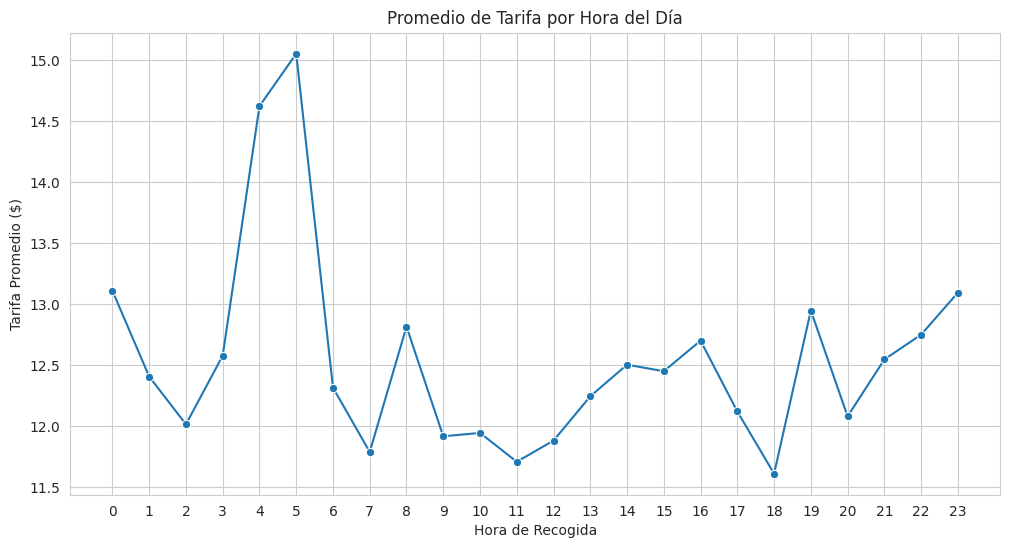

<ipython-input-35-d1b6bf9dc09a>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




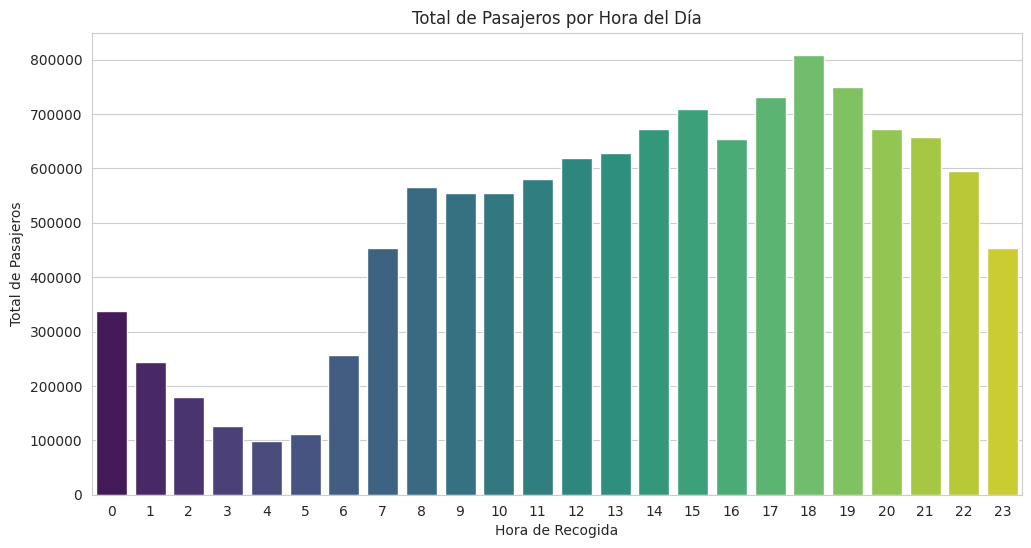

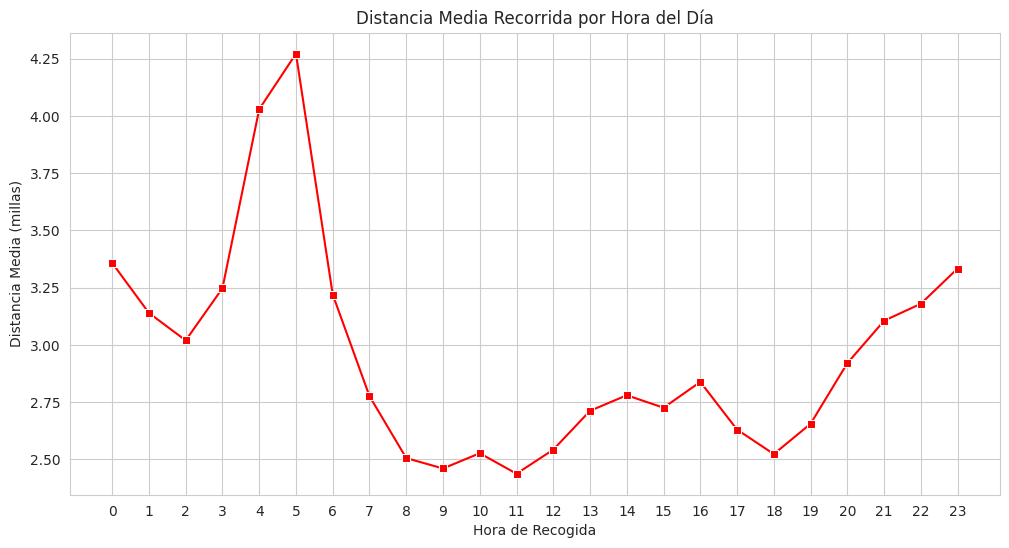

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'pandas_agg_df' not in globals():
    print("Pandas DataFrame 'pandas_agg_df' no encontrado.")
else:
    # Configurar estilo de los gráficos
    sns.set_style("whitegrid")

    # 1. Promedio de tarifa por hora
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='pickup_hour', y='avg_fare', data=pandas_agg_df, marker='o')
    plt.title('Promedio de Tarifa por Hora del Día')
    plt.xlabel('Hora de Recogida')
    plt.ylabel('Tarifa Promedio ($)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()

    # 2. Total de pasajeros por hora
    plt.figure(figsize=(12, 6))
    sns.barplot(x='pickup_hour', y='total_passengers', data=pandas_agg_df, palette='viridis')
    plt.title('Total de Pasajeros por Hora del Día')
    plt.xlabel('Hora de Recogida')
    plt.ylabel('Total de Pasajeros')
    plt.xticks(range(0, 24))
    plt.show()

    # 3. Distancia media recorrida por hora
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='pickup_hour', y='avg_distance', data=pandas_agg_df, marker='s', color='red')
    plt.title('Distancia Media Recorrida por Hora del Día')
    plt.xlabel('Hora de Recogida')
    plt.ylabel('Distancia Media (millas)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()

### (Opcional) Visualización con Plotly para interactividad
Plotly puede crear gráficos interactivos que pueden ser útiles.

In [ ]:
import plotly.express as px

if 'pandas_agg_df' not in globals():
    print("Pandas DataFrame 'pandas_agg_df' no encontrado.")
else:
    # 1. Promedio de tarifa por hora con Plotly
    fig_fare = px.line(pandas_agg_df, x='pickup_hour', y='avg_fare', title='Promedio de Tarifa por Hora (Plotly)', markers=True)
    fig_fare.update_xaxes(title='Hora de Recogida', tickvals=list(range(24)))
    fig_fare.update_yaxes(title='Tarifa Promedio ($)')
    fig_fare.show()

    # 2. Total de pasajeros por hora con Plotly
    fig_passengers = px.bar(pandas_agg_df, x='pickup_hour', y='total_passengers', title='Total de Pasajeros por Hora (Plotly)')
    fig_passengers.update_xaxes(title='Hora de Recogida', tickvals=list(range(24)))
    fig_passengers.update_yaxes(title='Total de Pasajeros')
    fig_passengers.show()

# ⏰ Parte 8: Automatización con Triggers (Consideraciones en Colab)

## ¿Qué es un trigger y por qué es útil?
Un **trigger** permite ejecutar automáticamente un notebook sin intervención manual. En Databricks, esto se gestiona con "Jobs".

## Automatización en Google Colab:
Google Colab (versión gratuita) no tiene una funcionalidad integrada para programar la ejecución de notebooks de forma nativa como los Jobs de Databricks.

### Opciones y Consideraciones:
1.  **Ejecución Manual**: Es la forma más directa en Colab. Abres el notebook y ejecutas las celdas.
2.  **Colab Pro/Pro+**: Las versiones de pago de Colab pueden ofrecer ejecuciones en segundo plano más largas, pero no una programación tipo cron directa.
3.  **Soluciones Externas (Avanzado)**:
    *   **Google Cloud Scheduler + Cloud Functions + Colab API (o Papermill)**: Podrías configurar un programador de Google Cloud para invocar una Cloud Function que, a su vez, ejecute el notebook de Colab. Esto es complejo y requiere conocimientos de Google Cloud Platform.
    *   **Scripts locales con `jupyter nbconvert --execute` o Papermill**: Podrías tener un script en una máquina local o un servidor que ejecute el notebook periódicamente, pero esto elimina la ventaja de estar "en la nube" de Colab para la ejecución.

Para los fines de este proyecto educativo adaptado a Colab, asumiremos que la ejecución es manual. La automatización completa como se describe para Databricks requeriría herramientas y configuraciones adicionales fuera del alcance de un notebook de Colab estándar.

# 🔍 Glosario Rápido (Adaptado para Colab)

- **PySpark**: La API de Python para Apache Spark.
- **SparkSession**: El punto de entrada para programar Spark con la API de DataFrame y Dataset.
- **DataFrame**: Una colección distribuida de datos organizada en columnas con nombre, similar a una tabla en una base de datos relacional o un data frame en R/Python (Pandas), pero distribuida.
- **ETL**: Extracción, Transformación y Carga de datos.
- **Parquet**: Un formato de archivo columnar eficiente para almacenamiento de datos.
- **Google Colab**: Un entorno de notebook basado en la nube que permite ejecutar código Python, incluyendo PySpark con la configuración adecuada.

# 📈 Anexo: Buenas prácticas para la visualización de dashboards (Aplicable a gráficos en Colab)

Un dashboard (o un conjunto de visualizaciones en un notebook) bien diseñado debe ser claro, funcional y enfocado en las necesidades del usuario final. Aquí tienes algunas recomendaciones:

### ✅ Claridad visual
- Usa títulos descriptivos en cada gráfico.
- Agrupa visualizaciones relacionadas.
- Usa colores coherentes y evita combinaciones confusas.
- Etiqueta claramente los ejes.

### 📊 Elección del gráfico adecuado
- **Barras**: Ideales para comparar cantidades entre categorías (ej. pasajeros por hora).
- **Líneas**: Para mostrar tendencias a lo largo del tiempo o una secuencia continua (ej. tarifa promedio por hora).
- **Tablas**: Para mostrar detalles específicos o valores exactos.
- **Histogramas/Densidad**: Para entender la distribución de una variable numérica.
- **Gráficos de dispersión**: Para explorar relaciones entre dos variables numéricas.

### 🔍 Enfoque en los KPIs
- No sobrecargues con demasiados gráficos: enfócate en los indicadores clave que respondan a preguntas concretas.
- Usa títulos que respondan a una pregunta: "¿A qué hora hay más pasajeros?", "¿Cuándo son más largos los viajes?"

### 🛠 Consideraciones en Colab
- Asegúrate de que las celdas de visualización se ejecuten correctamente y muestren los gráficos esperados.
- Considera usar librerías como Plotly si necesitas interactividad (zoom, tooltips) en tus gráficos dentro del notebook.